In [2]:
# !pip install tensorflow==2.14.0 tensorflow-probability==0.22.0


Total reward after 200 iterations: 56
[-1.         -0.2        -0.25       -1.          0.38285714]


In [ ]:
import numpy as np

class SimplePostureBandit:
    def __init__(self, k=5, iterations=200, change_probability=0.3, seed=22):
        self.k = k  # Number of actions
        self.iterations = iterations
        self.actions = ['up', 'down', 'right', 'left', 'stay']
        self.q_values = np.zeros(k)  # Estimated reward values
        self.action_counts = np.zeros(k)  # Count of actions taken
        self.total_reward = 0
        self.change_probability = change_probability
        self.current_state = 'same_posture'  # Initial state
        # Set the seed for reproducibility
        np.random.seed(seed)

    def get_reward(self, action):
        # Simulate state transition
        if np.random.rand() < self.change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on state and action
        if self.current_state == 'changed_posture':
            # Let's assume changing posture is generally good
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        return reward

    def select_action(self):
        # Using epsilon-greedy strategy
        epsilon = 0.1
        if np.random.rand() < epsilon:
            return np.random.choice(range(self.k))  # Explore
        else:
            return np.argmax(self.q_values)  # Exploit

    def update_q_values(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.q_values[action] += alpha * (reward - self.q_values[action])

    def run(self):
        for _ in range(self.iterations):
            action = self.select_action()
            reward = self.get_reward(action)
            self.update_q_values(action, reward)
            self.total_reward += reward

        print(f"Total reward after {self.iterations} iterations: {self.total_reward}")
        return self.q_values

if __name__ == "__main__":
    bandit = SimplePostureBandit()
    q = bandit.run()
    print(q)

True values: [0.]
Value estimates: [-0.35714286 -0.71428571 -1.         -0.22222222  0.        ]
Action counts: [14.  7.  5. 18. 28.]


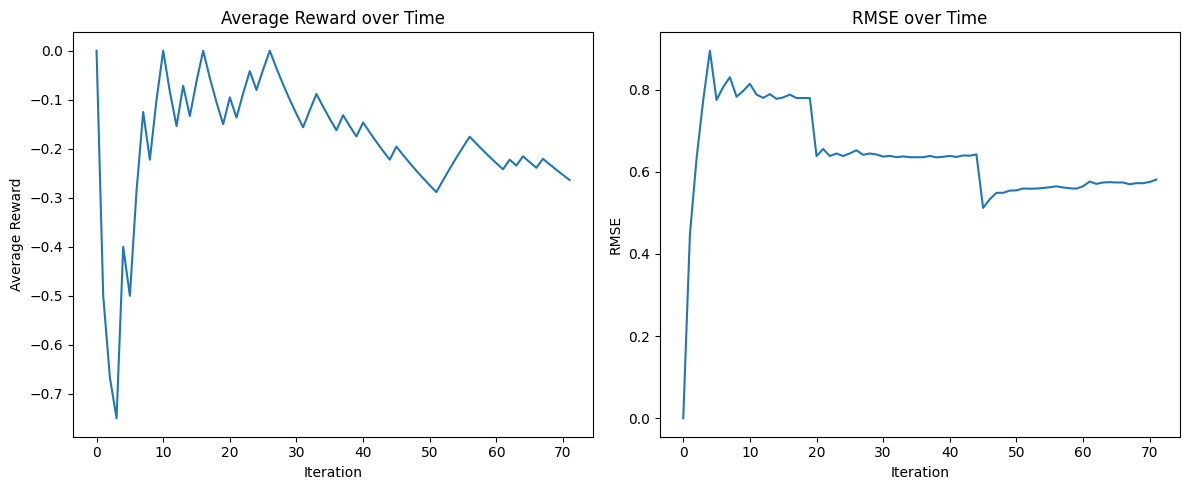

In [5]:
import numpy as np
import tensorflow as tf
import tf_agents.environments as tf_env
import tf_agents.specs as tf_specs
from tf_agents.trajectories import time_step as ts
from tf_agents.trajectories import trajectory

class FiveArmedBanditEnv(tf_env.py_environment.PyEnvironment):
    def __init__(self, user_model_vec, change_probability=0.3, seed=42):
        self._num_actions = 5
        self._user_model_vec = user_model_vec
        self._change_probability = change_probability
        self._step_count = 0
        self._total_reward = 0.0
        self._dummy_observation = np.array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=np.float32)
        np.random.seed(seed)
        super(FiveArmedBanditEnv, self).__init__()

    def action_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(), dtype=np.int32, minimum=0, maximum=self._num_actions - 1, name='action')

    def observation_spec(self):
        return tf_specs.BoundedArraySpec(
            shape=(self._num_actions,), dtype=np.float32, minimum=0, name='observation')

    def _reset(self):
        self._step_count = 0
        self._total_reward = 0.0
        return ts.restart(observation=self._dummy_observation)

    def _step(self, action):
        if np.random.uniform(0, 1) < self._change_probability:
            self.current_state = 'changed_posture'
        else:
            self.current_state = 'same_posture'

        # Define rewards based on the state and action
        if self.current_state == 'changed_posture':
            reward = 1 if action != 4 else -1  # Positive reward for any action except 'stay'
        else:
            reward = -1 if action != 4 else 1  # Negative reward for any action except 'stay'

        self._step_count += 1
        self._total_reward += reward -0.01  # Add a small penalty for each step

        return ts.transition(observation=self._dummy_observation, reward=reward)

    def get_total_reward(self):
        return self._total_reward

    def get_step_count(self):
        return self._step_count

class UCB1Agent:
    def __init__(self, num_actions, explore_rate=2.0):
        self.num_actions = num_actions
        self.explore_rate = explore_rate
        self.action_counts = np.zeros(num_actions)
        self.action_values = np.zeros(num_actions)
        self.total_steps = 0

    def select_action(self):
        ucb_values = self.action_values + self.explore_rate * np.sqrt(np.log(self.total_steps + 1) / (self.action_counts + 1))
        return np.argmax(ucb_values)

    def update_estimates(self, action, reward):
        self.total_steps += 1
        self.action_counts[action] += 1
        alpha = 1 / self.action_counts[action]
        self.action_values[action] += alpha * (reward - self.action_values[action])

    def get_current_average_reward(self):
        return np.sum(self.action_values * self.action_counts) / np.sum(self.action_counts)

def user_simulation(user_model_vec, num_iterations=72, explore_rate=2.0):
    # Create the environment
    env = FiveArmedBanditEnv(user_model_vec)

    # Create the UCB1 agent
    agent = UCB1Agent(num_actions=env.action_spec().maximum + 1, explore_rate=explore_rate)

    average_rewards = []
    rmse = []

    # Training loop
    for _ in range(num_iterations):
        # Main stepping
        action = agent.select_action()
        time_step = env.step(action)
        agent.update_estimates(action, time_step.reward)

        # Logs for plotting
        average_rewards.append(agent.get_current_average_reward())
        true_action_value = 2 * np.array(user_model_vec) - 1
        rmse.append(np.sqrt(np.mean((np.subtract(agent.action_values, true_action_value))**2)))

    print("True values: {}".format(true_action_value))
    print("Value estimates: {}".format(agent.action_values))
    print("Action counts: {}".format(agent.action_counts))

    return average_rewards, rmse

if __name__ == "__main__":
    user_model_vec = [0.5]  # Example user model vector
    average_rewards, rmse = user_simulation(user_model_vec)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(average_rewards)
    plt.xlabel('Iteration')
    plt.ylabel('Average Reward')
    plt.title('Average Reward over Time')

    plt.subplot(1, 2, 2)
    plt.plot(rmse)
    plt.xlabel('Iteration')
    plt.ylabel('RMSE')
    plt.title('RMSE over Time')

    plt.tight_layout()
    plt.show()


In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)

TensorFlow version: 2.14.0
TensorFlow Probability version: 0.22.0
